### Extreme precipitation events

Precipitation data is typically characterized by a highly skewed distribution, with a large mass near zero and a small number of extreme events.

These extreme events can disproportionately influence regression metrics and model behavior.
Extreme precipitation events are rare but contribute disproportionately to error-based metrics such as RMSE.

This raises the question of whether the model should:
- prioritize average behavior
- or better capture extreme events

### 1. EDA — Precipitation Distribution

Start by analyzing the empirical distribution of daily precipitation values.

In [ ]:
# Load daily dataset
import sys
from pathlib import Path
from src.config import RAW_DATASET
# Allow importing project modules
PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))

df = pd.read_csv(RAW_DATASET, parse_dates=["date"])
df.head()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Column name (string)
TARGET_COL = "precipitation_sum"

# Target series
precip = df[TARGET_COL]

# Basic statistics
precip.describe(percentiles=[0.9, 0.95, 0.99])

count    12784.000000
mean         3.114330
std          7.160786
min          0.000000
90%          8.600000
95%         14.100000
99%         29.700000
max        195.900000
Name: precipitation_sum, dtype: float64

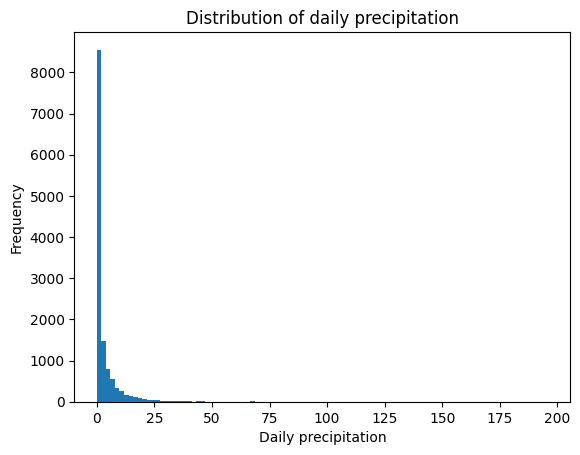

In [40]:
# Histogram (linear scale)
plt.figure()
plt.hist(precip, bins=100)
plt.xlabel("Daily precipitation")
plt.ylabel("Frequency")
plt.title("Distribution of daily precipitation")
plt.show()

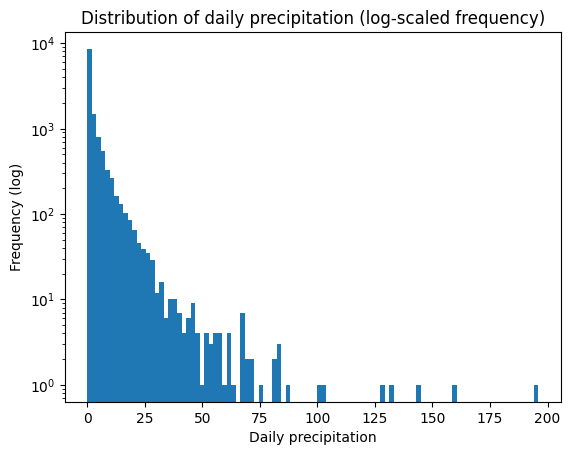

In [41]:
# Histogram (log-scaled y-axis)
plt.figure()
plt.hist(precip, bins=100)
plt.yscale("log")
plt.xlabel("Daily precipitation")
plt.ylabel("Frequency (log)")
plt.title("Distribution of daily precipitation (log-scaled frequency)")
plt.show()

### Observation

Precipitation shows a highly right-skewed distribution.

Most observations are near zero, with a small number of very large values.

### 2. Identification of Extreme Events

Extreme events are defined using empirical percentiles.

In [42]:
# Percentile thresholds
p90, p95, p99 = np.percentile(precip, [90, 95, 99])

p90, p95, p99

(np.float64(8.6), np.float64(14.1), np.float64(29.7))

In [43]:
# Proportion of extreme events
n_total = len(precip)

extreme_summary = pd.DataFrame({
    "threshold": ["p90", "p95", "p99"],
    "value": [p90, p95, p99],
    "share_of_observations_%": [
        (precip >= p90).mean() * 100,
        (precip >= p95).mean() * 100,
        (precip >= p99).mean() * 100,
    ]
})

extreme_summary

,threshold,value,share_of_observations_%
0,p90,8.6,10.114205
1,p95,14.1,5.068836
2,p99,29.7,1.009074


### Observation

Extreme precipitation events are rare by construction (e.g., ~1% above p99).

Despite their rarity, they contribute disproportionately to squared-error metrics such as RMSE.

### 3. Conceptual Impact on Modeling

Extreme precipitation events raise an important modeling question:

Should the model prioritize average-day accuracy, or rare but impactful extreme events?

Key considerations:

RMSE heavily penalizes large errors on extreme events.

MAE is more robust but still influenced by tails.

Most ML models trained with standard losses implicitly focus on the conditional mean.

This motivates evaluating alternative target treatments.

### 4. Optional Evaluation — Log-Transform of the Target

A common approach to reduce the influence of extreme values is applying a log-transform.

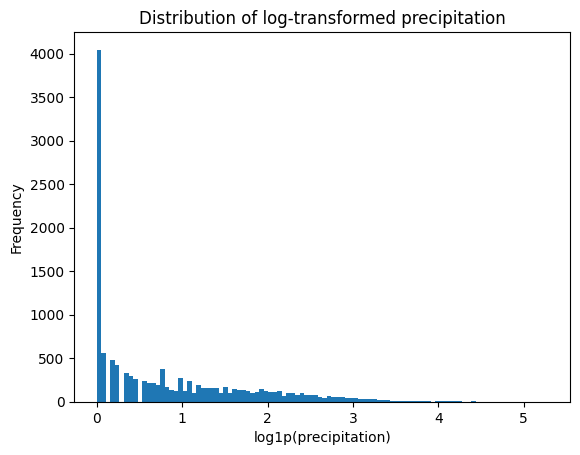

In [44]:
# Log-transform target
precip_log = np.log1p(precip)

# Compare distributions
plt.figure()
plt.hist(precip_log, bins=100)
plt.xlabel("log1p(precipitation)")
plt.ylabel("Frequency")
plt.title("Distribution of log-transformed precipitation")
plt.show()

# Qualitative assessment

The log-transform compresses extreme values.

The transformed distribution is closer to symmetric.

However, interpretation of predictions becomes less direct and requires inverse transformation.

(Quantitative performance comparison with and without log-transform is evaluated separately in modeling notebooks.)

# 5. Discussion of Alternative Treatments (No Implementation)

### Quantile-based losses

Directly target conditional quantiles instead of the mean.

Better suited for extreme-event modeling.

Not adopted at this stage to keep the modeling framework comparable across algorithms.

### Target capping

Example: cap precipitation at the 99th percentile.

Improves numerical stability.

Rejected to avoid removing physically meaningful extreme events.

# 6. Conclusion

Daily precipitation exhibits a strongly skewed distribution with rare but extreme events.

These events have a disproportionate impact on error-based metrics.

Multiple treatment options were evaluated conceptually and empirically.

For this project, the original target scale is retained to preserve physical interpretability.

All assumptions regarding extreme events are now explicit and documented.

No silent assumptions remain regarding precipitation outliers.